In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import pandas as pd

data = pd.read_csv("data_prepped_r.csv")
X = data.drop("Target", axis=1)
y = data["Target"]

# Define feature types (verify with your dataset)
one_hot_columns = [
    "Marital status",
    "Application mode",
    "Course",
    "Previous qualification (grade)",
    "Nacionality",
    "Mother's qualification",
    "Father's qualification",
    "Mother's occupation",
    "Father's occupation",
]

numeric_columns = [col for col in X.columns if col not in one_hot_columns]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), one_hot_columns)
    ])

logreg_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='saga', max_iter=5000))
])

param_grid = {
    'classifier__penalty': ['l1', 'l2', 'elasticnet'],
    'classifier__C': [0.1, 0.15, 0.3],
    'classifier__class_weight': [None, 'balanced'],
    'classifier__l1_ratio': [0.3, 0.35, 0.4]
}

grid_search = GridSearchCV(
    logreg_pipe,
    param_grid,
    cv=5,
    scoring='neg_log_loss',
    n_jobs=-1,
    return_train_score=True
)

grid_search.fit(X, y)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation log loss: {-grid_search.best_score_:.3f}")

/home/david/miniforge3/envs/ds/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/david/miniforge3/envs/ds/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/david/miniforge3/envs/ds/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/david/miniforge3/envs/ds/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/david/miniforge3/envs/ds/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'el

Best parameters: {'classifier__C': 0.3, 'classifier__class_weight': None, 'classifier__l1_ratio': 0.4, 'classifier__penalty': 'l1'}
Best cross-validation log loss: 0.231


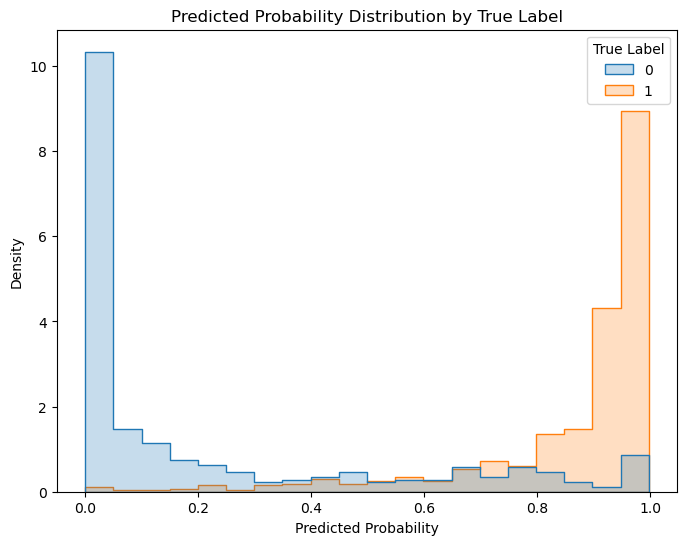

In [7]:
import seaborn as sns

# Create DataFrame with true labels and probabilities
prob_df = pd.DataFrame({'True Label': y_test_binary, 'Predicted Probability': y_proba})

# Plot
plt.figure(figsize=(8,6))
sns.histplot(
    data=prob_df,
    x='Predicted Probability',
    hue='True Label',
    element='step',
    stat='density',
    common_norm=False,
    bins=20
)
plt.title('Predicted Probability Distribution by True Label')
plt.show()

In [9]:
# Convert True Label to 1 for positive class, 0 otherwise
#prob_df['True Label'] = (prob_df['True Label'] == 'Graduate').astype(int)

# Now run your existing code
prob_df['Bin'] = pd.qcut(y_proba, q=5, duplicates='drop')
calibration_table = prob_df.groupby('Bin').agg(
    Mean_Predicted=('Predicted Probability', 'mean'),
    Observed_Positive_Rate=('True Label', 'mean'),
    Count=('True Label', 'count')
).reset_index()

print(calibration_table)


                   Bin  Mean_Predicted  Observed_Positive_Rate  Count
0  (-0.000923, 0.0425]        0.012493                0.016949    177
1       (0.0425, 0.65]        0.302266                0.305085    177
2        (0.65, 0.911]        0.803676                0.790960    177
3       (0.911, 0.966]        0.943315                0.960452    177
4       (0.966, 0.998]        0.979250                0.943503    177


/tmp/ipykernel_16579/726020279.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calibration_table = prob_df.groupby('Bin').agg(


In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curves(y_true, y_probs):
    """
    y_true: array-like, true labels
    y_probs_dict: dict, with model names as keys and predicted probabilities as values
    """
    plt.figure(figsize=(8, 6))
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

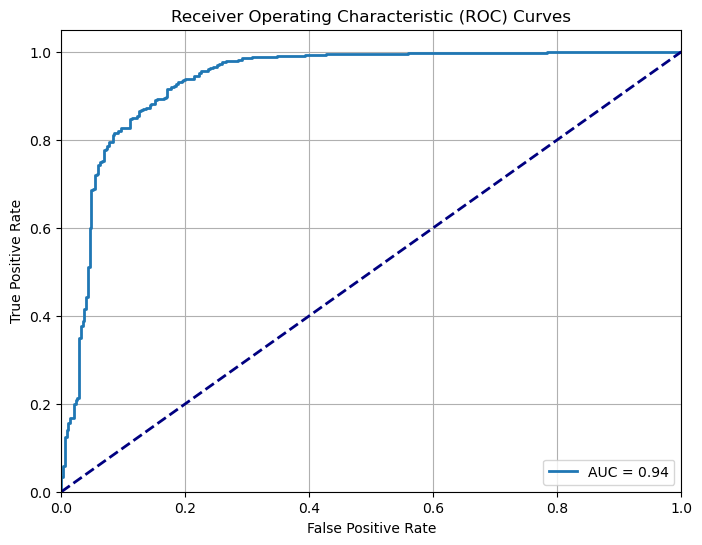

In [18]:
plot_roc_curves(y_test_binary, y_proba)

Cross-validation misclassified samples: 491
Total misclassified samples: 462
   Marital status  Application mode  Application order  Course  \
0               1                15                  1    9254   
1               2                39                  1    9991   
2               1                39                  1    9991   
3               1                39                  1    9130   
4               1                 1                  3    9147   

   Daytime/evening attendance\t  Previous qualification  \
0                             1                       1   
1                             0                      19   
2                             0                       1   
3                             1                      40   
4                             1                       1   

   Previous qualification (grade)  Nacionality  Mother's qualification  \
0                           160.0            1                       1   
1                      

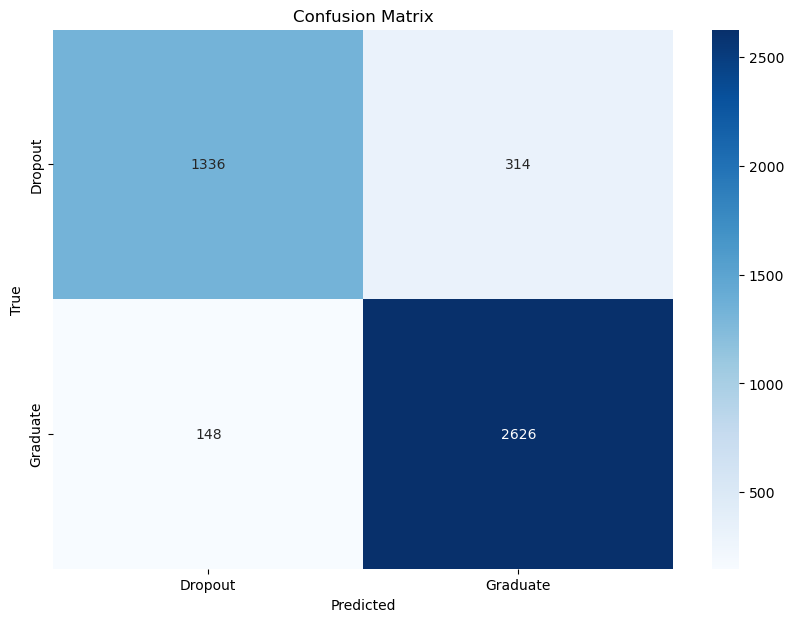


Index: 1
Features:
   Marital status  Application mode  Application order  Course  \
1               1                15                  1    9254   

   Daytime/evening attendance\t  Previous qualification  \
1                             1                       1   

   Previous qualification (grade)  Nacionality  Mother's qualification  \
1                           160.0            1                       1   

   Father's qualification  ...  \
1                       3  ...   

   Curricular units 1st sem (without evaluations)  \
1                                               0   

   Curricular units 2nd sem (credited)  Curricular units 2nd sem (enrolled)  \
1                                    0                                    6   

   Curricular units 2nd sem (evaluations)  \
1                                       6   

   Curricular units 2nd sem (approved)  Curricular units 2nd sem (grade)  \
1                                    6                         13.666667   



In [11]:
transformed_features = grid_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
#print("Transformed features:", transformed_features)

from sklearn.model_selection import cross_val_predict
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get cross-validated predictions
cv_preds = cross_val_predict(grid_search.best_estimator_, X, y, cv=5)

# Find CV misclassifications
cv_misclassified = np.where(y != cv_preds)[0]
print(f"Cross-validation misclassified samples: {len(cv_misclassified)}")




# Get predictions from best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X)
y_proba = best_model.predict_proba(X)

# Find misclassified samples
misclassified_mask = y != y_pred
misclassified_indices = np.where(misclassified_mask)[0]

# Create analysis DataFrame
analysis_df = pd.DataFrame({
    'TrueLabel': y.iloc[misclassified_indices],
    'PredictedLabel': y_pred[misclassified_indices],
    'Probability': np.max(y_proba[misclassified_indices], axis=1),
    'Index': misclassified_indices
})

# Add original features
misclassified_samples = X.iloc[misclassified_indices].copy()
misclassified_samples = pd.concat([
    misclassified_samples.reset_index(drop=True),
    analysis_df.reset_index(drop=True)
], axis=1)

print(f"Total misclassified samples: {len(misclassified_samples)}")
print(misclassified_samples.head())

# Visualize confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y, y_pred), 
            annot=True, fmt='d',
            cmap='Blues',
            xticklabels=best_model.named_steps['classifier'].classes_,
            yticklabels=best_model.named_steps['classifier'].classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Function to inspect individual misclassified samples
def inspect_misclassification(index):
    sample = X.iloc[index:index+1]
    print(f"\nIndex: {index}")
    print("Features:")
    print(sample)
    print(f"\nTrue label: {y.iloc[index]}")
    print(f"Predicted label: {y_pred[index]}")
    print(f"Class probabilities: {dict(zip(best_model.classes_, y_proba[index]))}")

# Example usage
inspect_misclassification(misclassified_indices[0])
